# Mahan Madani
## Artificial Neural Networks 4th Project


In [1]:
import torch
import torchvision as tv
from torchvision import transforms
import torch.nn as nn
import torch.utils.data as data

import matplotlib.pyplot as plt
import numpy as np

from time import time
import random

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("using cuda device")
    
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

using cuda device


### Download and load CIFAR10 Dataset + additional helper functions and classes:


In [3]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = tv.datasets.CIFAR10("./data", download=True, train=True, transform=transform)

Files already downloaded and verified


The ImageCombiner class receives the index of 2 pictures (from the main dataset) and combines them together. 

In [4]:
class ImageCombiner():
    def __init__(self, image_1_index, image_2_index):
        self.i = min(image_1_index, image_2_index)
        self.j = max(image_1_index, image_2_index)
    
    def get_image_1(self):
        return dataset[self.i][0]
    
    def get_image_2(self):
        return dataset[self.j][0]
    
    def get_label_1(self):
        return dataset[self.i][1]
    
    def get_label_2(self):
        return dataset[self.j][1]
    
    def get_combined_image(self):
        return (dataset[self.i][0] + dataset[self.j][0]) / 2


The transpose method is later used to display image tensors with matplotlib

In [5]:
def transpose(image):
    image = torch.transpose(image, 0, 2)
    image = torch.transpose(image, 0, 1)
    return image

The CIFAR10 dataset consists of 10 different classes, the dictionary below can be used to identify each class

In [6]:
classes = {0: "Airplane", 1: "Automobile", 2: "Bird", 3: "Cat", 4: "Deer",
           5: "Dog", 6: "Frog", 7: "Horse", 8: "Ship", 9: "Truck"}

We will create a list of all possible image combinations and store each combination alongside its original images. The first 1000 images from the dataset are chosen and then we calculate the combinations.

In [7]:
SAMPLE_SIZE = 1000
combined_images_dataset = []

for i in range(SAMPLE_SIZE):
    for j in range(i, SAMPLE_SIZE):      
        combiner = ImageCombiner(i, j)  
        combined_images_dataset.append( (combiner.get_combined_image(), combiner.get_image_1(), combiner.get_image_2()) )
        
len(combined_images_dataset)

500500

Shuffling the combined images is an important step in order to prevent overfitting, otherwise our decoders will only learn the first few images. The dataloader below is later used to train our model.

In [8]:
combined_image_dataloader = data.DataLoader(combined_images_dataset, batch_size=128, shuffle=True)

### Example of a combined image

Automobile + Dog


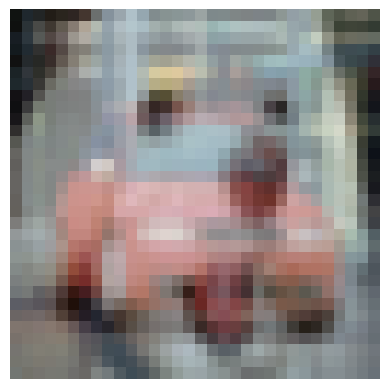

In [9]:
combiner = ImageCombiner(2094, 2095)
print(classes[combiner.get_label_1()] + " + " + classes[combiner.get_label_2()])
plt.imshow(transpose( combiner.get_combined_image() ))
plt.axis("off")
plt.show()

## Encoder and Decoder Classes

In [10]:
class Encoder(nn.Module): 
    def __init__(self):
        super().__init__()
        
        # input: 3, 32, 32
        self.block = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # 16, 16, 16
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=1, padding=0), # 32, 14, 14
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=1, padding=0), # 64, 12, 12
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=0), # 64, 10, 10
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=1, padding=0), # 64, 8, 8
            nn.ReLU(),
            nn.Conv2d(128, 128, 8, stride=1, padding=0) # 128, 1, 1
        ).to(device)
         
        
    def forward(self, x):  
        x = self.block(x)
        return x


In [11]:
class Decoder(nn.Module): 
    def __init__(self, encoder, ID):
        super().__init__()
        
        self.train_loss_list = []
        self.ID = ID
        self.encoder = encoder
        
        self.block = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 8, stride=1, padding=0), # 64, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=0), # 64, 10, 10
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=0), # 64, 12, 12
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=1, padding=0), # 32, 14, 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=1, padding=0), # 16, 16, 16
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),  # 3, 32, 32
            nn.Sigmoid()
        ).to(device)

        
    def forward(self, x):
        x = self.encoder(x)
        x = self.block(x)  
        return x


## Training the model
In order to be able to decode two separate images from a single latent space, we use a single encoder and two decoders. Each decoder's job is to extract one of the corresponding images.

In [12]:
criterion = nn.MSELoss()

In [13]:
def train_model(model, optimizer_name, learning_rate):

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    total_loss = 0
    model.train()

    for combined_image, image_1, image_2 in combined_image_dataloader:
        image_1 = image_1.to(device)
        image_2 = image_2.to(device)
        combined_image = combined_image.to(device)

        #forward-pass
        output = model(combined_image)         ## output = reconstructed image

        if model.ID == 1:
            loss = criterion(output, image_1)
        elif model.ID == 2:
            loss = criterion(output, image_2)

        #backward-pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # At completion of epoch
    average_train_loss = total_loss / len(combined_image_dataloader)
    model.train_loss_list.append(average_train_loss)

    print(f"Decoder {model.ID} training loss: {average_train_loss: .6f}")


The two decoders are trained together alongside the shared encoder.

In [14]:
def run_model(decoder_1, decoder_2, optimizer_name, epochs, learning_rate):
    start_time = time()
    
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1: >3}/{epochs}:")
        train_model(decoder_1, optimizer_name, learning_rate)
        train_model(decoder_2, optimizer_name, learning_rate)
        
    end_time = time()
    print(f"Total time spent: {end_time - start_time} seconds")    
    

## Testing the model
Two random images are chosen from the sample space (the first 1000 images) and their average is given as input. Our model should be able to decode the 2 original images from the input.

In [15]:
def display_test_results(fig, combiner, model, test_count, x):
    
    combined_image = combiner.get_combined_image().to(device)
    output = model(combined_image)
    
    if model.ID == 1:
        original_image = combiner.get_image_1().to(device)
        label = combiner.get_label_1()
    elif model.ID == 2:
        original_image = combiner.get_image_2().to(device)
        label = combiner.get_label_2()
    
    loss = criterion(output, original_image)

    original_image = original_image.cpu()
    original_image = transpose(original_image)

    fig.add_subplot(test_count, 5, 5*x + 2*model.ID)
    plt.imshow(original_image)
    plt.axis("off")
    plt.title(f"Original Image {model.ID}: " + classes[label])
    
    output = output.cpu()
    output = transpose(output)

    fig.add_subplot(test_count, 5, 5*x + 2*model.ID + 1)
    plt.imshow(output)
    plt.axis("off")
    plt.title(f"Decoder {model.ID} Reconstructed Image ")
    
    return loss.item()


In [16]:
def test_model(decoder_1, decoder_2, test_count):
    if test_count <= 0:
        return
    
    with torch.no_grad():
        test_loss_1 = 0
        test_loss_2 = 0
        
        decoder_1.eval()
        decoder_2.eval()

        fig = plt.figure(figsize=(20, 5*test_count))

        for x in range(test_count):
            i = random.randint(0, SAMPLE_SIZE)
            j = random.randint(0, SAMPLE_SIZE)
            combiner = ImageCombiner(i, j)

            combined_image = combiner.get_combined_image().cpu()
            combined_image = transpose(combined_image)

            fig.add_subplot(test_count, 5, 5*x + 1)
            plt.imshow(combined_image)
            plt.axis("off")
            plt.title("Combined Image")

            test_loss_1 += display_test_results(fig, combiner, decoder_1, test_count, x)
            test_loss_2 += display_test_results(fig, combiner, decoder_2, test_count, x)

        test_loss_1 = test_loss_1 / (test_count)
        test_loss_2 = test_loss_2 / (test_count)

        print(f"average test loss of decoder 1: {test_loss_1: < .6f}")
        print(f"average test loss of decoder 2: {test_loss_2: < .6f}")
        

### Create the models and train them:

In [17]:
encoder = Encoder().to(device) 
decoder_1 = Decoder(encoder, ID=1).to(device)
decoder_2 = Decoder(encoder, ID=2).to(device)

### First 10 epochs:

In [18]:
run_model(decoder_1, decoder_2, "Adam", epochs=10, learning_rate=0.001)

Epoch:   1/10:
Decoder 1 training loss:  0.037110
Decoder 2 training loss:  0.028708
Epoch:   2/10:
Decoder 1 training loss:  0.023160
Decoder 2 training loss:  0.019688
Epoch:   3/10:
Decoder 1 training loss:  0.017722
Decoder 2 training loss:  0.016236
Epoch:   4/10:
Decoder 1 training loss:  0.015159
Decoder 2 training loss:  0.014321
Epoch:   5/10:
Decoder 1 training loss:  0.013650
Decoder 2 training loss:  0.013077
Epoch:   6/10:
Decoder 1 training loss:  0.012638
Decoder 2 training loss:  0.012189
Epoch:   7/10:
Decoder 1 training loss:  0.011881
Decoder 2 training loss:  0.011494
Epoch:   8/10:
Decoder 1 training loss:  0.011308
Decoder 2 training loss:  0.010988
Epoch:   9/10:
Decoder 1 training loss:  0.010848
Decoder 2 training loss:  0.010571
Epoch:  10/10:
Decoder 1 training loss:  0.010460
Decoder 2 training loss:  0.010221
Total time spent: 3302.1509761810303 seconds


average test loss of decoder 1:  0.013600
average test loss of decoder 2:  0.012593


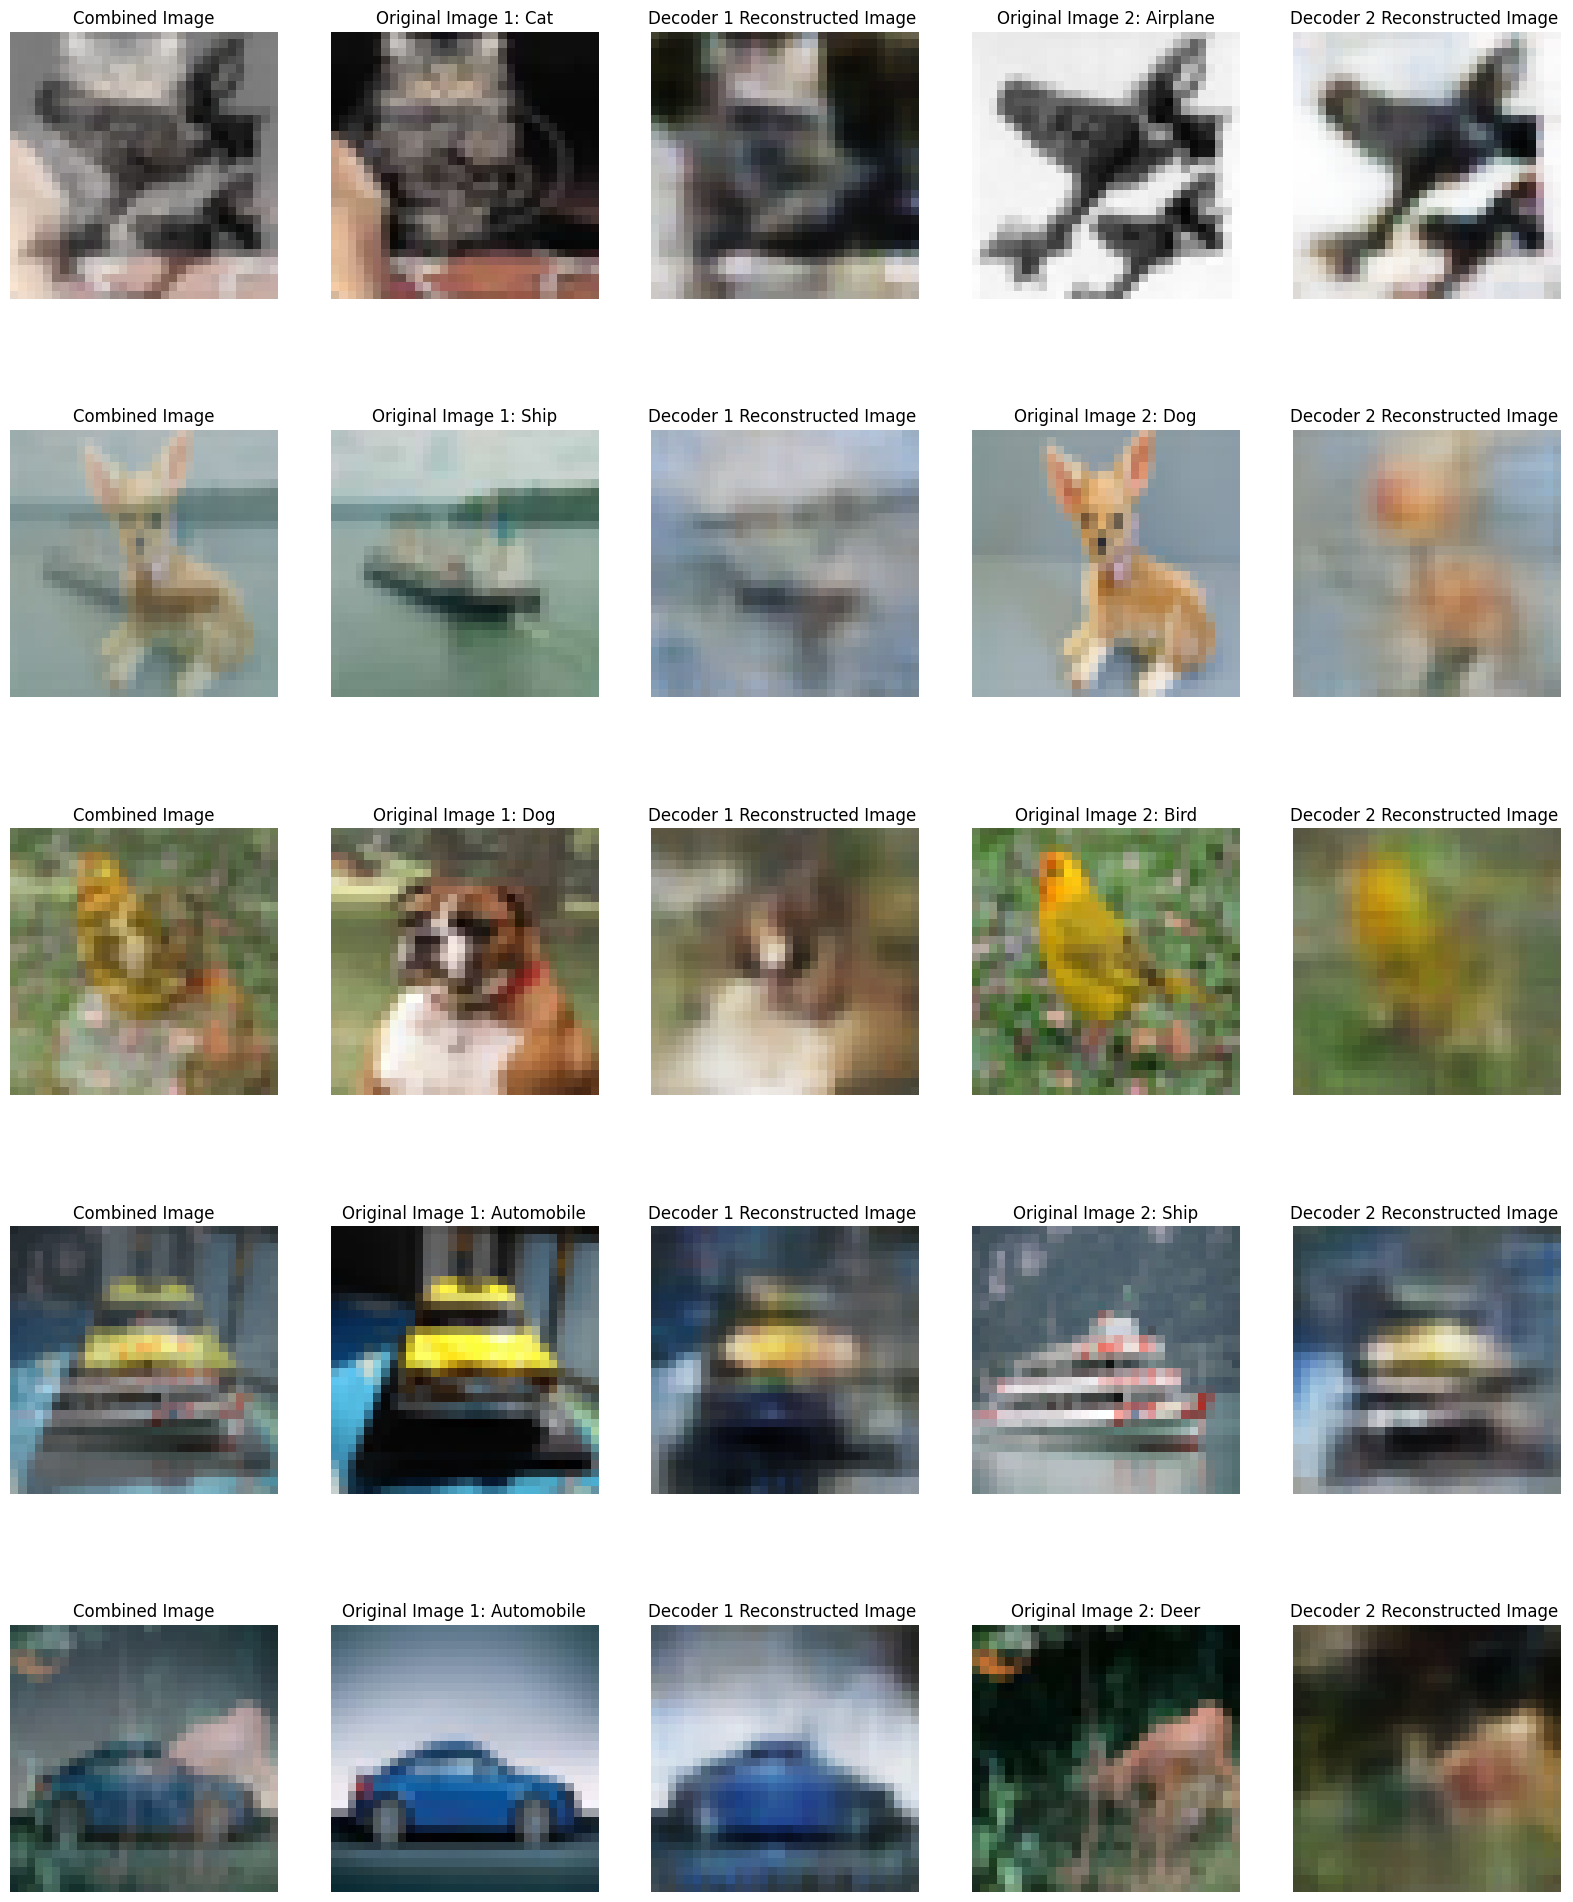

In [29]:
test_model(decoder_1, decoder_2, test_count=5)

the results are relatively accurate but they can definitely be improved
### 20 more epochs:

In [30]:
run_model(decoder_1, decoder_2, "Adam", epochs=20, learning_rate=0.001)

Epoch:   1/20:
Decoder 1 training loss:  0.009431
Decoder 2 training loss:  0.009522
Epoch:   2/20:
Decoder 1 training loss:  0.009223
Decoder 2 training loss:  0.009309
Epoch:   3/20:
Decoder 1 training loss:  0.009083
Decoder 2 training loss:  0.009123
Epoch:   4/20:
Decoder 1 training loss:  0.008925
Decoder 2 training loss:  0.008969
Epoch:   5/20:
Decoder 1 training loss:  0.008786
Decoder 2 training loss:  0.008789
Epoch:   6/20:
Decoder 1 training loss:  0.008678
Decoder 2 training loss:  0.008660
Epoch:   7/20:
Decoder 1 training loss:  0.008559
Decoder 2 training loss:  0.008543
Epoch:   8/20:
Decoder 1 training loss:  0.008461
Decoder 2 training loss:  0.008429
Epoch:   9/20:
Decoder 1 training loss:  0.008355
Decoder 2 training loss:  0.008331
Epoch:  10/20:
Decoder 1 training loss:  0.008262
Decoder 2 training loss:  0.008218
Epoch:  11/20:
Decoder 1 training loss:  0.008188
Decoder 2 training loss:  0.008154
Epoch:  12/20:
Decoder 1 training loss:  0.008123
Decoder 2 train

average test loss of decoder 1:  0.008025
average test loss of decoder 2:  0.005072


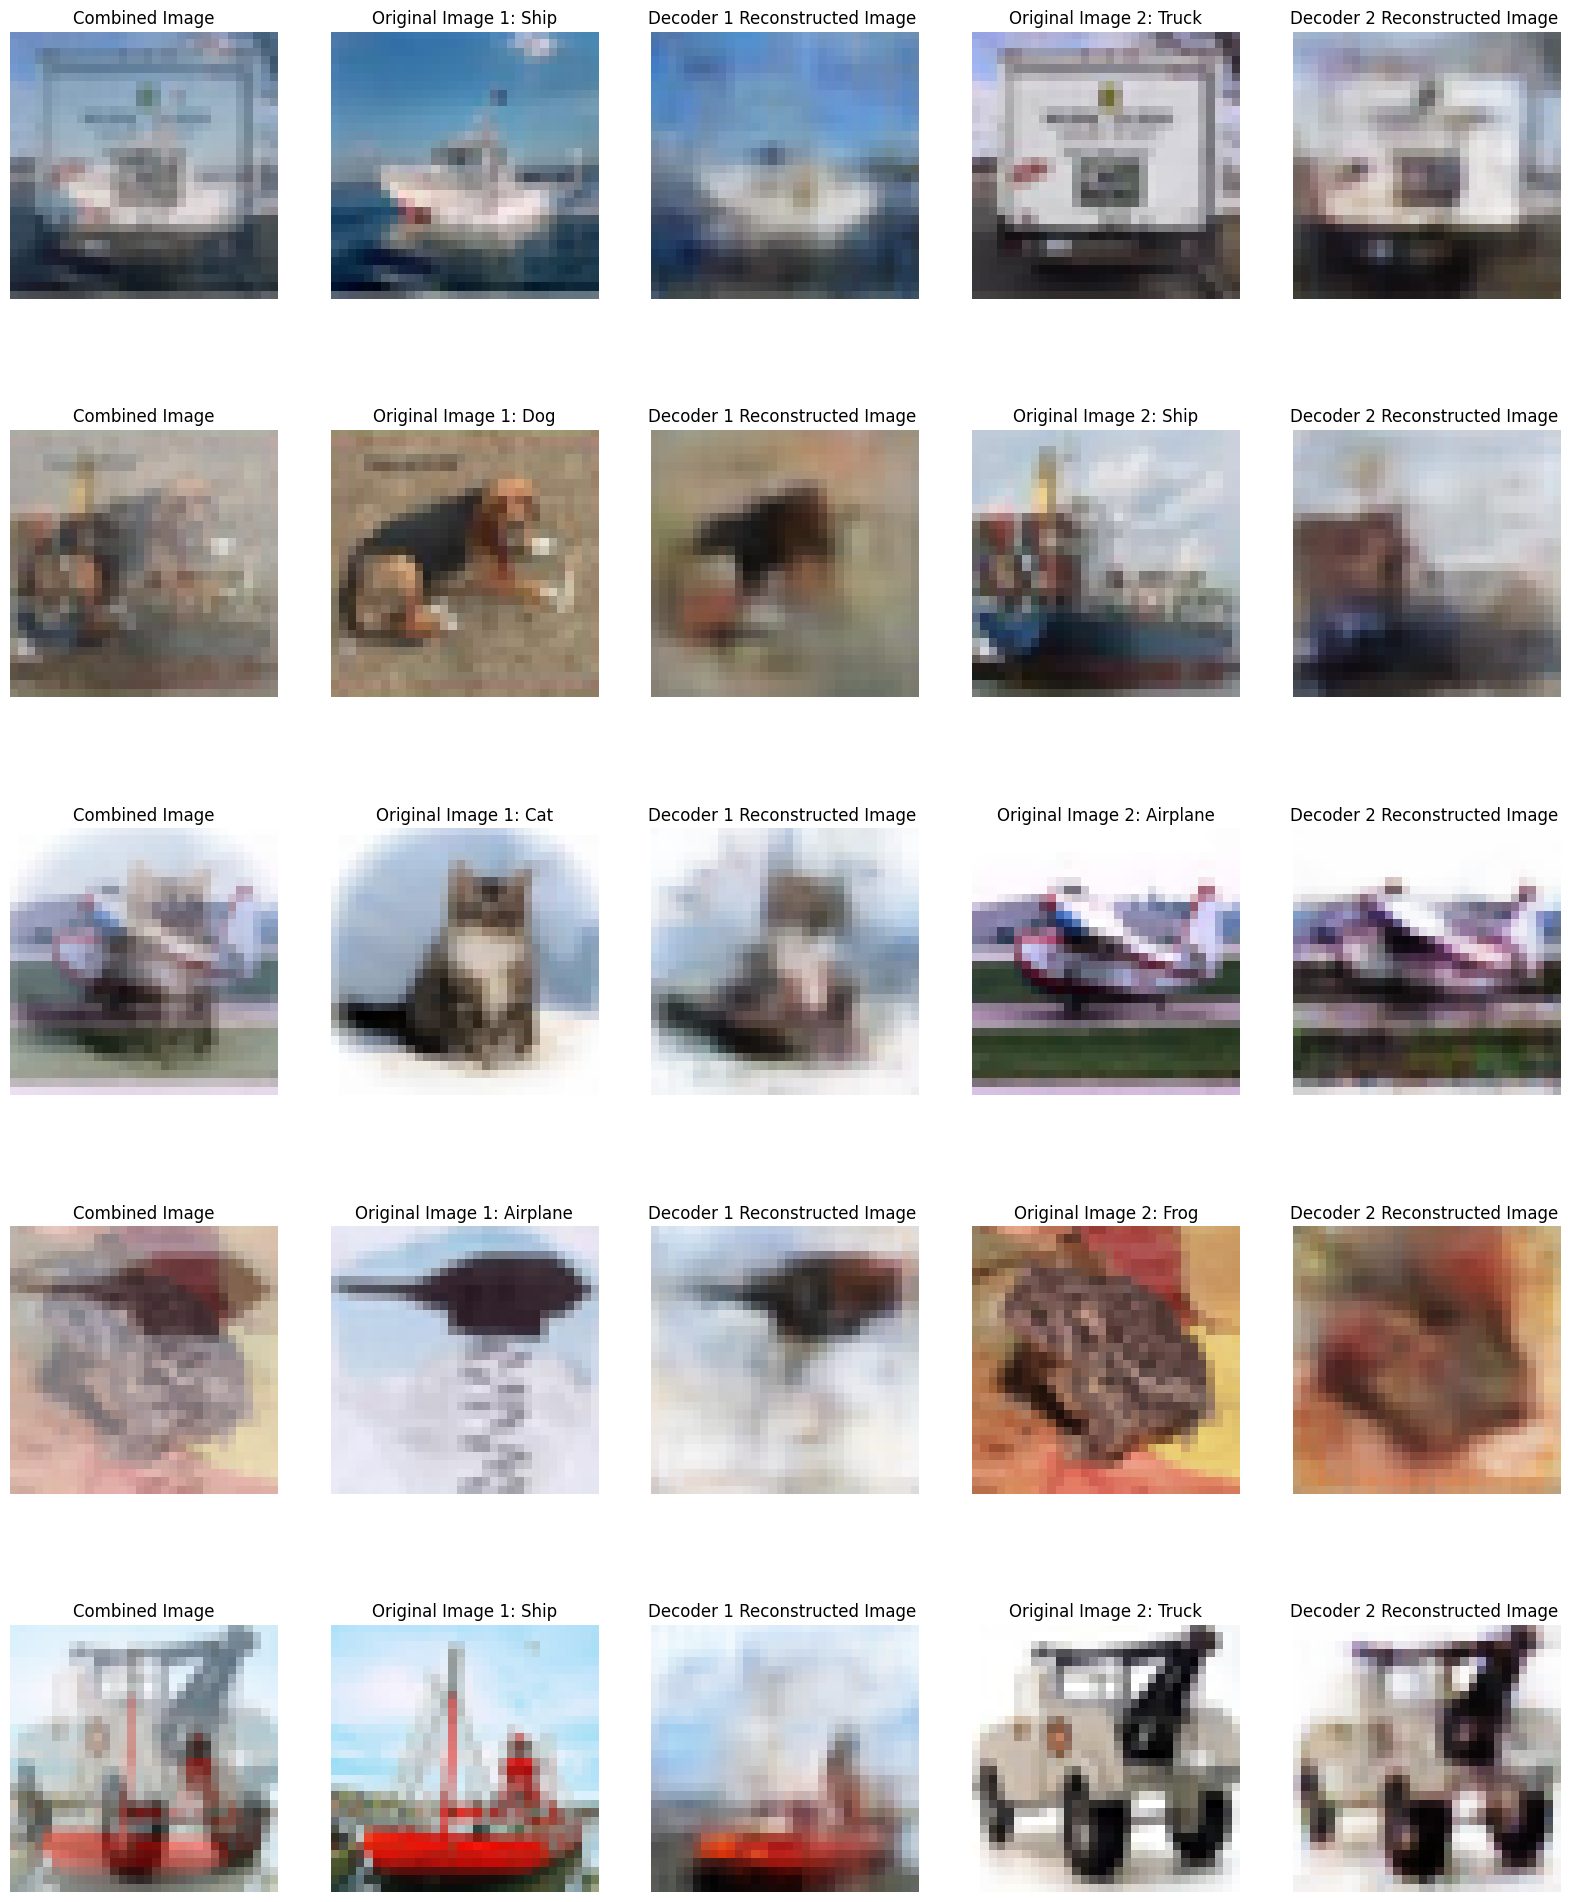

In [35]:
test_model(decoder_1, decoder_2, test_count=5)

We can see a clear improvement with more training, although training this network takes a long amount of time. We can predict that more training will probably lead to better results. Note that no matter how much training we do, the recounstructed images will still be a bit blurry. This is a downside of autoencoder archtitectures in general.

## Test: Basic Autoencoder Network:
<br> To ensure my Autoencoder model was able to encode and decode images successfully, I first created a basic version of the model to see if it could reconstruct normal images. Unlike the main question (which only required 1000 images), this model is trained on the full training dataset (50k images)

### Define train/test functions for basic network

In [36]:
dataloader = data.DataLoader(dataset, batch_size=128, shuffle=True)
criterion = nn.MSELoss()

In [37]:
def train_basic_model(model, optimizer_name, epochs, learning_rate):

    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(epochs):
        total_loss = 0
        model.train()

        for image, label in dataloader:
            #forward-pass
            image = image.to(device)
            output = model(image)             ## output = reconstructed image
            loss = criterion(output, image)

            #backward-pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # At completion of epoch
        average_train_loss = total_loss / len(dataloader)
        model.train_loss_list.append(average_train_loss)
        
        print(f"Epoch: {epoch+1: >3}/{epochs}   training loss: {average_train_loss: .6f}")

Testing the model is done by choosing a number of random images from the entire dataset, then reconstructing them with the model and calculating the loss

In [38]:
def test_basic_model(model, test_count):

    if test_count <= 0:
        return
    
    fig = plt.figure(figsize=(15, 5*test_count))
    plt.axis("off")

    with torch.no_grad():
        test_loss = 0
        model.eval()
        
        for i in range(test_count):
            image, label = dataset[random.randint(0, len(dataset))]
            image = image.to(device)

            output = model(image)
            loss = criterion(output, image)
            test_loss += loss.item()

            image = image.cpu()
            image = transpose(image)
            
            fig.add_subplot(test_count, 2, 2*i + 1)
            plt.imshow(image)
            plt.title("Original " + classes[label])
            
            output = output.cpu()
            output = transpose(output)
            
            fig.add_subplot(test_count, 2, 2*i + 2)
            plt.imshow(output)
            plt.title("Reconstructed " + classes[label])
            
        test_loss = test_loss / (test_count)
        print(f"average test loss: {test_loss: < .6f}")

In [39]:
def generate_loss_plot(model):
    plt.plot(model.train_loss_list, label = "Training loss")
    plt.legend(frameon = False)
    plt.show()

In [40]:
def run_basic_model(model, optimizer, epochs, learning_rate):
    start_time = time()
    train_basic_model(model, optimizer, epochs, learning_rate)
    generate_loss_plot(model)
    end_time = time()
    print(f"Total time spent: {end_time - start_time} seconds")

Epoch:   1/20   training loss:  0.032751
Epoch:   2/20   training loss:  0.019846
Epoch:   3/20   training loss:  0.015892
Epoch:   4/20   training loss:  0.012548
Epoch:   5/20   training loss:  0.011154
Epoch:   6/20   training loss:  0.010308
Epoch:   7/20   training loss:  0.009570
Epoch:   8/20   training loss:  0.008951
Epoch:   9/20   training loss:  0.008471
Epoch:  10/20   training loss:  0.008002
Epoch:  11/20   training loss:  0.007520
Epoch:  12/20   training loss:  0.007097
Epoch:  13/20   training loss:  0.006748
Epoch:  14/20   training loss:  0.006459
Epoch:  15/20   training loss:  0.006242
Epoch:  16/20   training loss:  0.006029
Epoch:  17/20   training loss:  0.005813
Epoch:  18/20   training loss:  0.005689
Epoch:  19/20   training loss:  0.005545
Epoch:  20/20   training loss:  0.005415


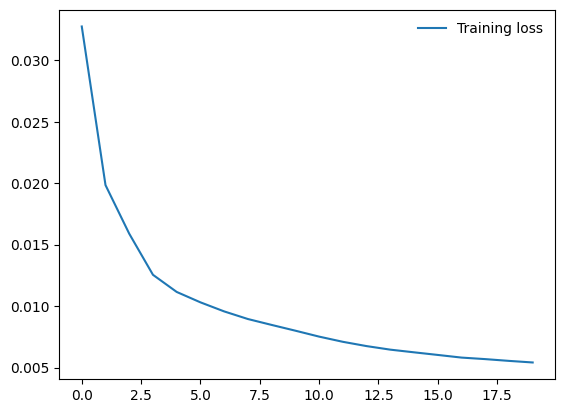

Total time spent: 211.36930108070374 seconds


In [115]:
basic_encoder = Encoder().to(device) 
basic_decoder = Decoder(basic_encoder, 3).to(device)
run_basic_model(basic_decoder, "Adam", epochs=20, learning_rate=0.001)

As you can see below, the model can reconstruct images with an accepetable level of accuracy.

average test loss:  0.005165


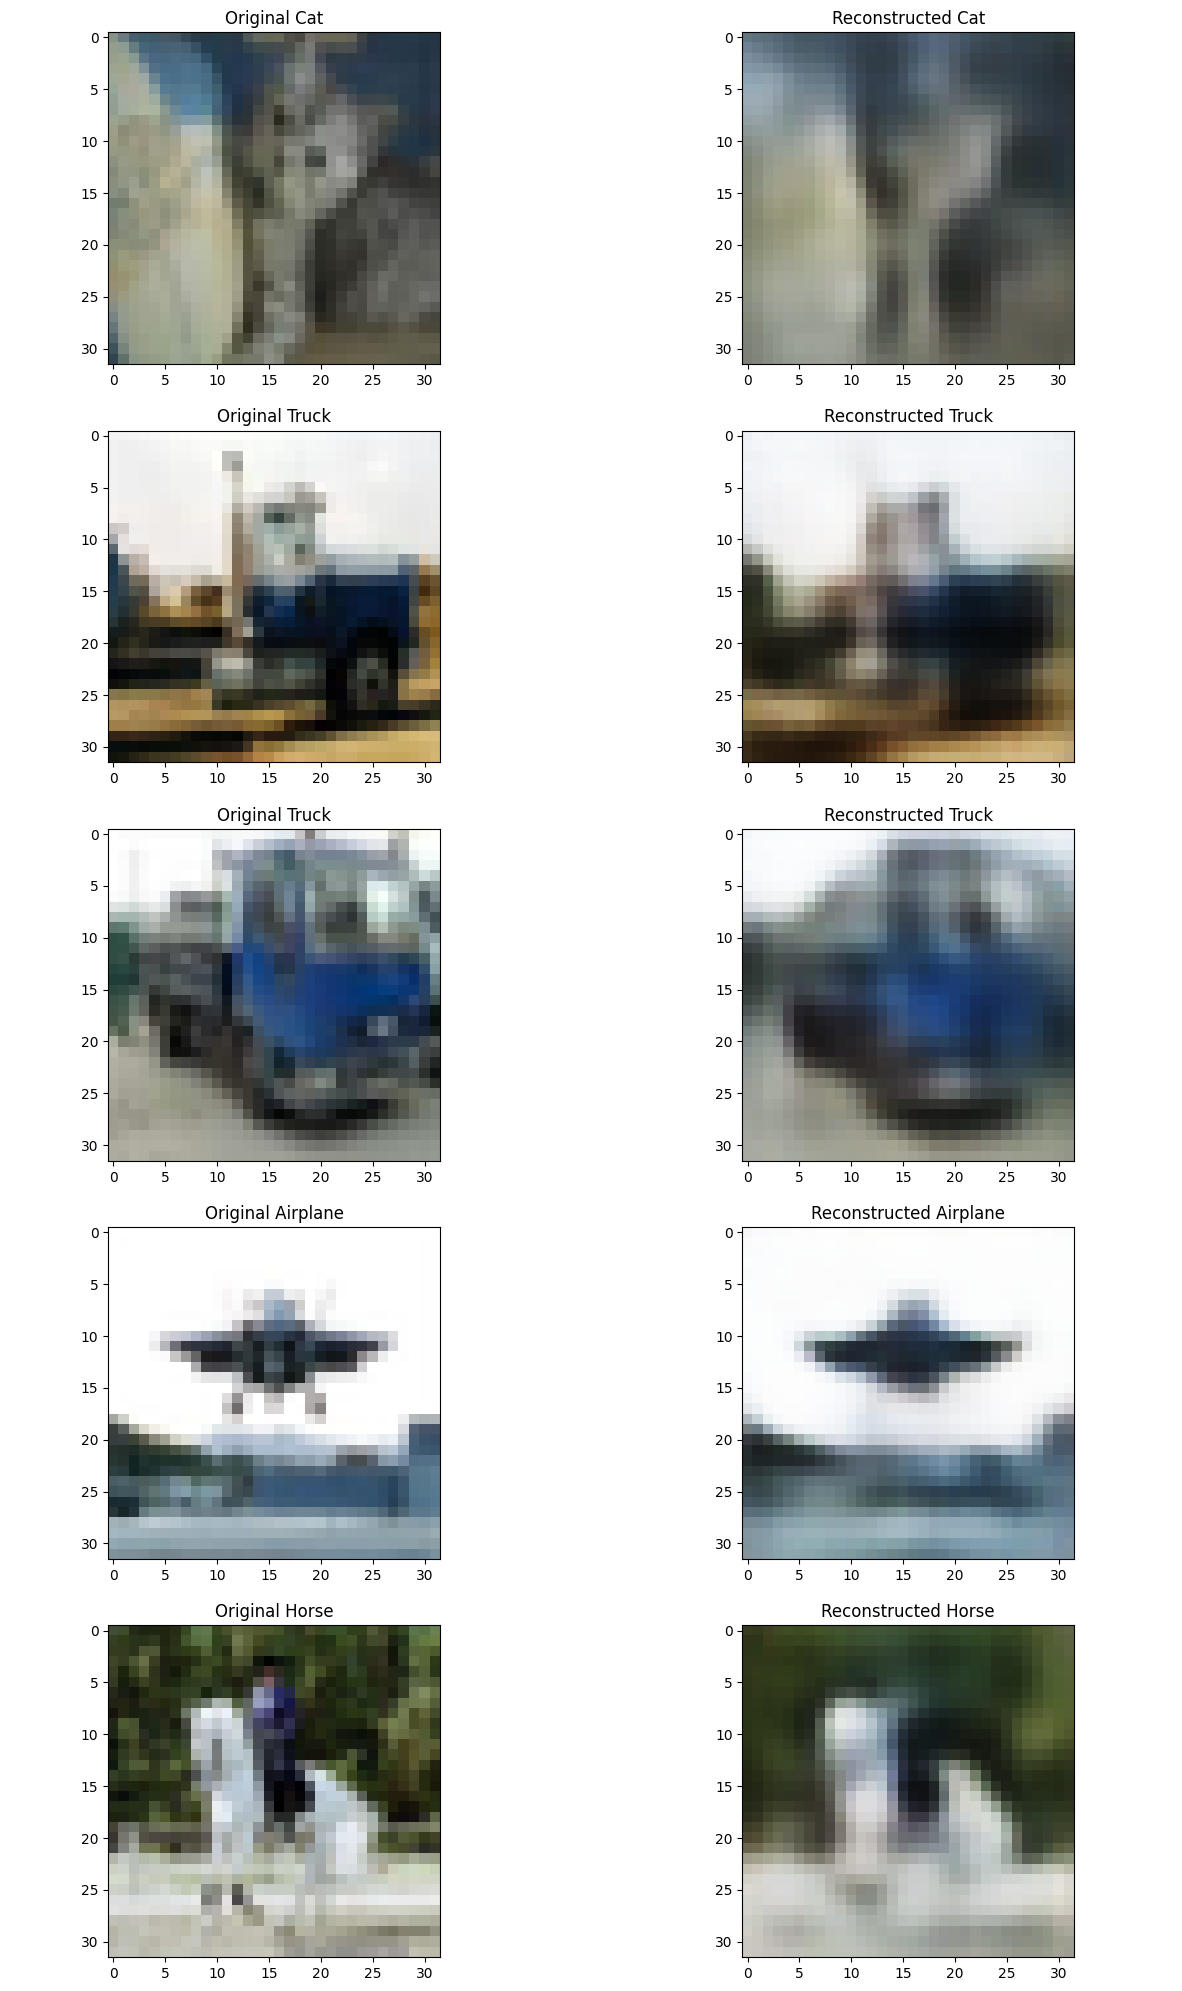

In [116]:
test_basic_model(basic_decoder, 5)